Please request an api key at:
https://app.canalyst.com/settings/api-tokens

## KPI Rank Order
### (For a different ticker edit second code cell)

In [1]:
import sys
import os
import dtale
import dtale.app as dtale_app
dtale_app.JUPYTER_SERVER_PROXY = True
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import canalyst_candas.candas as cd
import canalyst_candas.candas_datareader as cdr
from canalyst_candas.configuration.config import Config
config_info = {
  "canalyst_api_key": "",
  "s3_access_key_id": "",
  "s3_secret_key": "",
  "fred_key": "",
  "default_dir": "",
  "mds_host": "",
  "wp_host": ""
}
config = Config(config=config_info)
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

A configuration file has been created for you in 
/home/canalyst-candas/canalyst/keys.json. For Excel file downloads and scenario 
mapping, you'll need to add an API key to the 'canalyst_api_key' 
value. Visit https://app.canalyst.com/settings/api-tokens to create 
and retrieve your API key. You will also need to retrieve your 
S3 Access ID and Secret Key and fill in 'canalyst_s3_id' and 
'canalyst_s3_key' with those values, respectively. If using a 
Jupyter Notebook, stop and restart the notebook for the changes to 
take effect. If using a Python/iPython session, quit the current 
session and start a new one.


<b>Key Parameters</b>

Establish our price ticker (data source yahoo finance) and our Canalyst ticker (we use Bloomberg ticker format)

In [2]:
ticker = "GS US"
yahoo_ticker = "GS" #need this for prices
index_ticker = "^GSPC" #this is our benchmark index (^GSPC for S&P 500, EFA for msci eafa etc)
alpha_days = "alpha_1_day" #or alpha_5_day or alpha_10_day
regression_window = 12
model_set = cd.ModelSet(ticker_list=[ticker], config=config) #create a modelset of our ticker

Check whether we cover this stock

In [3]:
#instantiate a search object, which we will also use later
search = cd.Search(config)
search.get_ticker_list(ticker = ticker) #do we cover this stock?

,File,Bloomberg Ticker,Thomson Ticker
1149,Goldman Sachs GS US,GS US,GS.N


Let's take a look at the list of available segments (categories) in the model.

In [4]:
categories = list(model_set.model_frame(ticker=ticker,
                      period_duration_type = "fiscal_quarter", 
                      mrq=True)['category'].unique())
categories

['Growth Analysis',
 'Segmented Results - Revenue Breakdown (FS)',
 'Segmented Results - Investment Banking (FS & PR & IP)',
 'Operating Stats - Investment Banking (MD&A)',
 'Key Metrics - Investment Banking (MD&A & IP)',
 'Segmented Results - Global Markets (FS & PR & IP)',
 'Key Metrics - Global Markets (MD&A & IP)',
 'Segmented Results - Asset Management (FS & PR & IP)',
 'Operating Stats - Asset Management (FS & PR)',
 'Key Metrics - Asset Management (MD&A)',
 'Segmented Results - Consumer & Wealth Management (FS & PR & IP)',
 'Operating Stats - Consumer & Wealth Management (FS & PR)',
 'Key Metrics - Consumer & Wealth Management (MD&A)',
 'Key Metrics - AUS by Asset Class (FS & PR)',
 'Key Metrics - Average Daily VaR (FS & PR)',
 'Segmented Results - Geographic Revenue Breakdown (FS)',
 'Key Metrics - Headcount (FS & PR)',
 'Segmented Results - Investment Banking (FS) (Historical)',
 'Operating Stats - Investment Banking (FS) (Historical)',
 'Segmented Results - Institutional Clie

Goal: Create a pivoted view of one category of the model_frame

In [5]:
model_set.model_frame(ticker=ticker,
                      category=categories[0], #filter to one or more category
                      period_duration_type = "fiscal_quarter", #only fiscal quarters
                      is_historical=True, #historical data only
                      pivot=True, #pivot the data so dates are on column headers
                     n_periods=regression_window).head()

period_name_sorted,ticker,name_index,category,time_series_name,time_series_description,is_driver,MRFQ,2018Q4,2019Q1,2019Q2,2019Q3,2019Q4,2020Q1,2020Q2,2020Q3,2020Q4,2021Q1,2021Q2,2021Q3
0,GS US,7,Growth Analysis,z_JAJJLJ0162_MO_GA_Financialadvisoryrevenuegrowth,"Financial Advisory revenue growth, %",False,Q3-2021,0.00000,0.00000,0.00000,0.00000,-28.63105,-10.64073,-11.02464,-27.25968,27.60234,43.02177,83.23615,225.04931
1,GS US,8,Growth Analysis,z_JAJJLJ0162_MO_GA_Underwritingrevenuegrowth,"Underwriting revenue growth, %",False,Q3-2021,0.00000,0.00000,0.00000,0.00000,31.31720,29.16667,106.76768,60.33708,67.96315,154.83871,7.13239,33.14646
2,GS US,9,Growth Analysis,z_JAJJLJ0162_MO_GA_CorporateLendingrevenuegrowth,"Corporate Lending revenue growth, %",True,Q3-2021,0.00000,0.00000,0.00000,0.00000,-7.56972,245.31250,-140.64171,-86.22047,-151.29310,-53.61991,-309.21053,334.28571
3,GS US,10,Growth Analysis,z_JAJJLJ0162_MO_OS_investmentbankingrevenuegrowth,"Investment Banking revenue growth, %",False,Q3-2021,0.00000,0.00000,0.00000,0.00000,-5.88235,25.08591,36.39630,6.95274,26.59884,72.66484,35.82988,87.91265
4,GS US,11,Growth Analysis,z_JAJJLJ0162_MO_OS_ficcexecutionrevenuegrowth,"FICC revenue growth, %",True,Q3-2021,0.00000,0.00000,0.00000,0.00000,62.74149,32.66309,148.82491,49.01727,6.16167,31.12159,-45.21842,0.23981


Next we set up a dataset which includes:
- a full modelframe of quarterly data 
- a set of earnings data, 
- rolling 252 day beta vs the S&P 500
- 1 and 5 and 10 day alpha (excess beta adjusted performance vs the S&P 500)

In [6]:
df_data = model_set.pe_dataset(ticker,yahoo_ticker,index_ticker)

In a separate example, we can:
    <br>- pull just the earnings and prices dataframe for this ticker 
    <br>- chart earnings surprise vs stock movement

In [7]:
df = cdr.get_earnings_and_prices(yahoo_ticker,index_ticker = index_ticker) 

In [8]:
df.tail()

,ticker,earnings_date,companyshortname,price_date,epsestimate,epsactual,epssurprisepct,alpha_1_day,alpha_5_day,alpha_10_day,beta_252,plus_1_return,plus_5_return,plus_10_return,mktclose_plus_1_return,mktclose_plus_5_return,mktclose_plus_10_return
46,GS,2020-10-14,"The Goldman Sachs Group, Inc.",2020-10-14,5.57000,8.98000,61.25000,-0.01049,-0.01985,-0.02152,1.28350,-0.01245,-0.03939,-0.10160,-0.00153,-0.01522,-0.06238
47,GS,2021-01-19,"The Goldman Sachs Group, Inc.",2021-01-19,7.47000,12.08000,61.63000,-0.03030,-0.05916,-0.03370,1.26456,-0.01268,-0.04228,-0.02458,0.01394,0.01335,0.00721
48,GS,2021-04-14,"The Goldman Sachs Group, Inc.",2021-04-14,10.22000,18.60000,81.94000,-0.00276,-0.01335,0.02232,1.10879,0.00954,-0.00024,0.03805,0.01109,0.01182,0.01419
49,GS,2021-07-13,"The Goldman Sachs Group, Inc.",2021-07-13,10.24000,15.02000,46.68000,-0.00517,-0.02110,-0.00914,0.82726,-0.00420,-0.02984,-0.00303,0.00116,-0.01056,0.00738
50,GS,2021-10-15,"The Goldman Sachs Group, Inc.",2021-10-15,10.18000,14.93000,46.72000,0.01535,0.00367,-0.01240,1.01208,0.01877,0.02032,0.01793,0.00337,0.01644,0.02997


We can use pandas' describe() function to get the mean eps surprise and subsequent stock movement for this stock.

In [9]:
df.describe().reset_index() #row 2 is the mean of the full series of data

,index,epsestimate,epsactual,epssurprisepct,alpha_1_day,alpha_5_day,alpha_10_day,beta_252,plus_1_return,plus_5_return,plus_10_return,mktclose_plus_1_return,mktclose_plus_5_return,mktclose_plus_10_return
0,count,51.00000,51.00000,51.00000,48.00000,48.00000,48.00000,48.00000,51.00000,51.00000,51.00000,51.00000,51.00000,51.00000
1,mean,4.04686,4.97569,11.82843,0.00036,-0.00289,0.00261,1.28137,-0.00061,-0.00076,0.00539,0.00104,0.00382,0.00484
2,std,2.08931,3.59819,73.12694,0.01295,0.02392,0.03027,0.21691,0.02312,0.03455,0.04209,0.00873,0.01801,0.02763
3,min,-0.16000,-0.84000,-434.76000,-0.03030,-0.07059,-0.07913,0.82726,-0.11556,-0.11633,-0.10160,-0.02214,-0.03067,-0.06238
4,25%,2.95500,2.94000,3.37000,-0.00612,-0.01606,-0.01641,1.14833,-0.01143,-0.02486,-0.01427,-0.00186,-0.00383,-0.00658
5,50%,3.82000,4.57000,20.44000,-0.00273,-0.00515,-0.00226,1.27697,0.00119,-0.00019,0.01323,0.00116,0.00519,0.00721
6,75%,4.85500,5.69500,39.42000,0.00709,0.01444,0.02122,1.42899,0.00993,0.01996,0.02993,0.00528,0.01303,0.01593
7,max,10.24000,18.60000,106.47000,0.03375,0.06742,0.07149,1.70759,0.03742,0.07090,0.08762,0.02963,0.05381,0.08145


Let's filter down to just a few categories, rather than all of them.

And let's regress EVERY time series name against n day alpha, over n regression periods (both specified above), and rank by r-squared.

In [10]:

like_list = ['Stats','Analysis','Metrics','Segmented Results']
category_filter = []
for category in categories:
    for like in like_list:
        if like in category:
            category_filter.append(category)
            
category_filter = list(set(category_filter))
category_filter


['Operating Stats - Investment Banking (FS) (Historical)',
 'Segmented Results - Investment Banking (FS & PR & IP)',
 'Segmented Results - Institutional Client Services (FS) (Historical)',
 'Key Metrics - Global Markets (MD&A & IP)',
 'Margin Analysis',
 'Segmented Results - Other (FS) (Historical)',
 'Key Metrics - Consumer & Wealth Management (MD&A)',
 'Segmented Results - Global Markets (FS & PR & IP)',
 'Segmented Results - Geographic Revenue Breakdown (FS)',
 'Key Metrics - Asset Management (MD&A)',
 'Operating Stats - Consumer & Wealth Management (FS & PR)',
 'Segmented Results - Consumer & Wealth Management (FS & PR & IP)',
 'Segmented Results - Revenue Breakdown (FS)',
 'Key Metrics - Headcount (FS & PR)',
 'Segmented Results - Investment Management (FS) (Historical)',
 'Key Metrics - AUS by Asset Class (FS & PR)',
 'Segmented Results - Investing & Lending (FS) (Historical)',
 'Operating Stats - Investment Management (FS) (Historical)',
 'Segmented Results - Investment Banking 

<AxesSubplot:title={'center':'GS US Key Drivers Price Sensitivity'}, ylabel='time_series_description'>

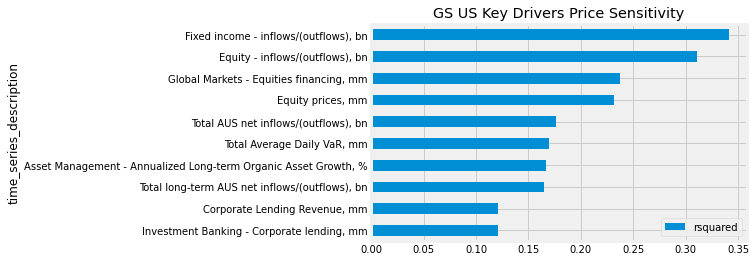

In [11]:
%matplotlib inline
df_kpi = cdr.regress_dataframe_time_series_groups(df_data = df_data,
                                         y_name=alpha_days,
                                         return_grouped=True,
                                         category = category_filter,
                                         n_periods=regression_window)
df_kpi = df_kpi[['ticker','time_series_description','time_series_name','category','rsquared']].head(10).sort_values('rsquared',ascending = True)
df_kpi.plot(x='time_series_description',y='rsquared',kind='barh',title=ticker+" Key Drivers Price Sensitivity")

We can see the price / time series history of the top KPI to check whether it makes sense

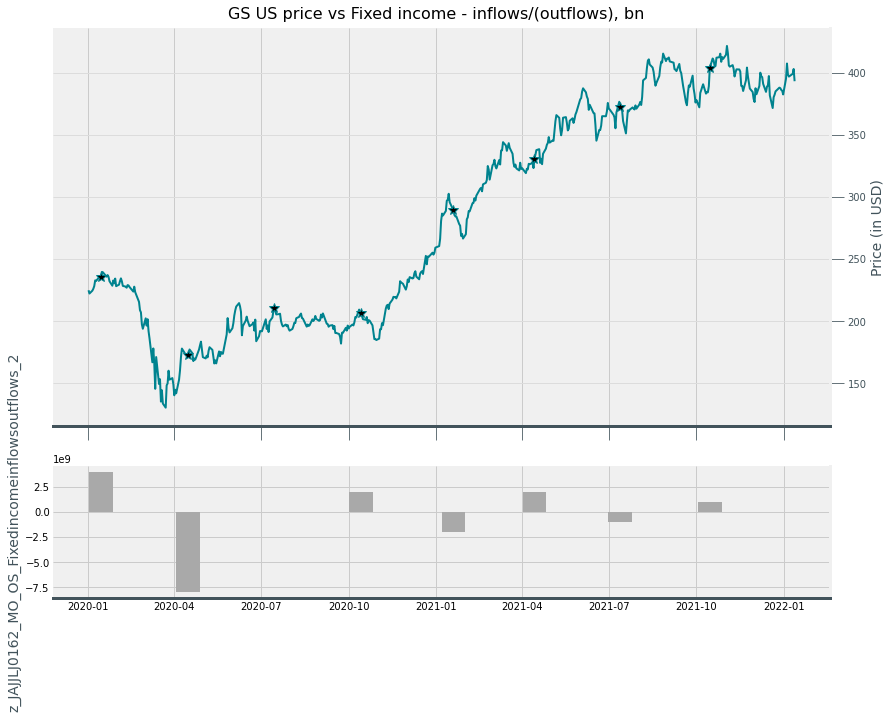

In [12]:
top_kpi = df_kpi.iloc[9]['time_series_name']
time_series_name=top_kpi
df_prices = cdr.get_price_data(yahoo_ticker, reset=True, rolling_betas=False, index_ticker=index_ticker)
cdr.plot_prices_against_time_series(df_data,df_prices,time_series_name,"value") #raw value

In a separate analysis, we can pull the key drivers off the precedent tree for revenue, and rank order their impact on revenue.

In [13]:

#use the same node tree to extract key drivers (red nodes)
df = model_set.models[ticker].key_driver_map("MO_RIS_REV")
return_series = 'MO_RIS_REV'
driver_list_df = []
for i, row in df.iterrows():

    time_series_name = row['time_series_name']
    print(f"scenario: move {time_series_name} 1% and get resultant change in {return_series}")

    #create a param dataframe for each time series name in our list
    df_1_param = model_set.forecast_frame(time_series_name,
                         n_periods=-1,
                         function_name='multiply',
                         function_value=1.01)


    d_output=model_set.fit(df_1_param,return_series) #our fit function will return a link to scenario engine JSON for audit

    df_output = model_set.filter_summary(d_output,period_type='Q')

    df_merge = pd.merge(df_output,df_1_param,how='inner',left_on=['ticker','period_name'],right_on=['ticker','period_name'])

    driver_list_df.append(df_merge) #append to a list for concatenating at the end
df = pd.concat(driver_list_df).sort_values('diff',ascending=False)
df = df.rename(columns={'time_series_name_y':'time_series_name'})
df['diff'] = df['diff']-1
df = df.sort_values('diff')


https://mds.canalyst.com/api/equity-model-series/JAJJLJ0162/equity-models/Q3-2021.22/time-series/MO_RIS_REV/forecast-data-points/Q4-2021/drivers/?format=dot
scenario: move z_JAJJLJ0162_MO_OS_CompletedMATransactionVolume_1 1% and get resultant change in MO_RIS_REV
GS US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/JAJJLJ0162/equity-models/Q3-2021.22/scenarios/I6H8e5LVUg6g7ehYveG81Q/
scenario: move z_JAJJLJ0162_MO_OS_ImpliedFinancialAdvisoryFeeRate_1 1% and get resultant change in MO_RIS_REV
GS US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/JAJJLJ0162/equity-models/Q3-2021.22/scenarios/xkp25wTpX-S0LGre4vWi9Q/
scenario: move z_JAJJLJ0162_MO_OS_EquityEquityRelatedOfferingVolume_1 1% and get resultant change in MO_RIS_REV
GS US scenario_id_url: https://mds.canalyst.com/api/equity-model-series/JAJJLJ0162/equity-models/Q3-2021.22/scenarios/THdTXo2XVoaA5v85d9da9A/
scenario: move z_JAJJLJ0162_MO_OS_ImpliedEquityUnderwritingFeeRate_1 1% and get resultan

<AxesSubplot:title={'center':'GS US Key Drivers Revenue Sensitivity'}, ylabel='time_series_description_y'>

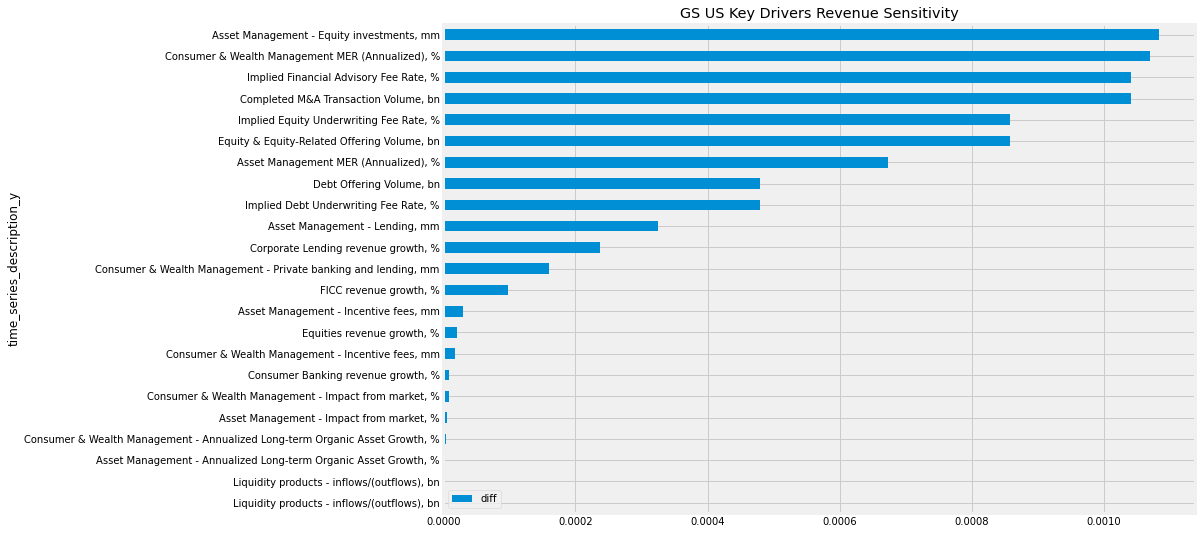

In [14]:
df.plot(x='time_series_description_y',y='diff',kind='barh',title=ticker+" Key Drivers Revenue Sensitivity")

In [15]:
#model_set = cd.ModelSet(ticker_list=[ticker], config=config) #create a modelset of our ticker
time_series_name="MO_RIS_REV"
model_map = model_set.create_model_map(ticker=ticker,
                            time_series_name=time_series_name,
                            tree = True,
                            notebook = True,
                            col_for_labels = "time_series_description") 
from IPython.display import IFrame
map_file=ticker.split(' ')[0]+'_'+time_series_name+'_model_map.html'
display(IFrame('canalyst/'+map_file, width='100%', height='1000px'))

https://mds.canalyst.com/api/equity-model-series/JAJJLJ0162/equity-models/Q3-2021.22/time-series/MO_RIS_REV/forecast-data-points/Q4-2021/drivers/?format=dot


In [16]:
df.sort_values('diff',ascending=False)

,ticker,period_name,time_series_name_x,time_series_description_x,default,scenario,diff,time_series_name,time_series_description_y,value,new_value,period_end_date
0,GS US,Q4-2021,MO_RIS_REV,Net Revenue,11532238418.03017,11544738418.0302,0.00108,z_JAJJLJ0162_MO_OS_Equityinvestments_1,"Asset Management - Equity investments, mm",1250000000.00000,1262500000.00000,2021-12-31
0,GS US,Q4-2021,MO_RIS_REV,Net Revenue,11532238418.03017,11544581338.4617,0.00107,z_JAJJLJ0162_MO_OS_ConsumerWealthManagementMERAnnualized,"Consumer & Wealth Management MER (Annualized), %",0.69774,0.70471,2021-12-31
0,GS US,Q4-2021,MO_RIS_REV,Net Revenue,11532238418.03017,11544238418.0302,0.00104,z_JAJJLJ0162_MO_OS_ImpliedFinancialAdvisoryFeeRate_1,"Implied Financial Advisory Fee Rate, %",0.40000,0.40400,2021-12-31
0,GS US,Q4-2021,MO_RIS_REV,Net Revenue,11532238418.03017,11544238418.0302,0.00104,z_JAJJLJ0162_MO_OS_CompletedMATransactionVolume_1,"Completed M&A Transaction Volume, bn",300000000000.00000,303000000000.00000,2021-12-31
0,GS US,Q4-2021,MO_RIS_REV,Net Revenue,11532238418.03017,11542138418.0302,0.00086,z_JAJJLJ0162_MO_OS_ImpliedEquityUnderwritingFeeRate_1,"Implied Equity Underwriting Fee Rate, %",3.30000,3.33300,2021-12-31
0,GS US,Q4-2021,MO_RIS_REV,Net Revenue,11532238418.03017,11542138418.0302,0.00086,z_JAJJLJ0162_MO_OS_EquityEquityRelatedOfferingVolume_1,"Equity & Equity-Related Offering Volume, bn",30000000000.00000,30300000000.00000,2021-12-31
0,GS US,Q4-2021,MO_RIS_REV,Net Revenue,11532238418.03017,11540006281.8198,0.00067,z_JAJJLJ0162_MO_OS_AssetManagementMERAnnualized,"Asset Management MER (Annualized), %",0.18150,0.18331,2021-12-31
0,GS US,Q4-2021,MO_RIS_REV,Net Revenue,11532238418.03017,11537763418.0302,0.00048,z_JAJJLJ0162_MO_OS_DebtOfferingVolume_1,"Debt Offering Volume, bn",65000000000.00000,65650000000.00000,2021-12-31
0,GS US,Q4-2021,MO_RIS_REV,Net Revenue,11532238418.03017,11537763418.0302,0.00048,z_JAJJLJ0162_MO_OS_ImpliedDebtUnderwritingFeeRate_1,"Implied Debt Underwriting Fee Rate, %",0.85000,0.85850,2021-12-31
0,GS US,Q4-2021,MO_RIS_REV,Net Revenue,11532238418.03017,11535988418.0302,0.00033,z_JAJJLJ0162_MO_OS_Lending_1,"Asset Management - Lending, mm",375000000.00000,378750000.00000,2021-12-31


A configuration file has been created for you in 
/home/canalyst-candas/canalyst/keys.json. For Excel file downloads and scenario 
mapping, you'll need to add an API key to the 'canalyst_api_key' 
value. Visit https://app.canalyst.com/settings/api-tokens to create 
and retrieve your API key. You will also need to retrieve your 
S3 Access ID and Secret Key and fill in 'canalyst_s3_id' and 
'canalyst_s3_key' with those values, respectively. If using a 
Jupyter Notebook, stop and restart the notebook for the changes to 
take effect. If using a Python/iPython session, quit the current 
session and start a new one.
A configuration file has been created for you in 
/home/canalyst-candas/canalyst/keys.json. For Excel file downloads and scenario 
mapping, you'll need to add an API key to the 'canalyst_api_key' 
value. Visit https://app.canalyst.com/settings/api-tokens to create 
and retrieve your API key. You will also need to retrieve your 
S3 Access ID and Secret Key and fill in 'canalyst_s3